# Fatty Liver Disease (FLD) Study

- alcoholic vs non-alcoholic FLD, short: AFLD vs NAFLD


**Outline**

1. Study on liver disease types:
    1. Fibrosis
    1. Steatosis
    2. Inflammation
    
2. Two data sets with 
    1. clinical markers
    2. proteome information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.linear_model as skllm
import sklearn.ensemble as skle

import sklearn.metrics as sklm
import sklearn.model_selection as sklms
from sklearn.model_selection import cross_val_predict

import xgboost
import ipywidgets as widgets

In [2]:
import src.utils as utils

In [3]:
import os
CPUS = os.cpu_count()
RANDOMSTATE = 29
DATAFOLDER = 'processed/ML'

# Explore datasets

Diagnostic comparators (existing best-in-class) biomarkers
- Fibrosis markers: transient elastography, 2-dimensional shear wave elastography, ELF test, FibroTest, FIB4 score, APRI score, Forns score, ProC3
- Inflammation markers: M30=caspase-cleaved cytokeratin-18 fragments, M65=total CK18, AST:ALT ratio, ProC3
- Steatosis: Controlled attenuation parameter

In [4]:
pd.set_option('max_columns', 9)

files = [file for file in os.listdir(DATAFOLDER) if '.csv' in file]
w_data = widgets.Dropdown(options=files, index=5)

def show_data(file):
    filename = os.path.join(DATAFOLDER, file)
    global data # only here to show-case data for report
    try:
        data = pd.read_csv(filename, index_col='Sample ID')
    except:
        data = pd.read_csv(filename)
    display(data.head())
out = widgets.interactive_output(show_data, controls={'file':w_data})

widgets.VBox([w_data, out])

In [5]:
# # Possible Alternative for DropDown 
# from src.widgets import multi_checkbox_widget

# descriptions=data.columns
# w_cols = multi_checkbox_widget(descriptions)
# w_cols

In [6]:
w_cols = widgets.SelectMultiple(options=list(data.columns))

def show_selected_proteins(columns):
    if len(columns)> 0:
        display(data[list(w_cols.value)])
        print(data[list(w_cols.value)].describe())
    else:
        print('Select proteins')

out_sel = widgets.interactive_output(show_selected_proteins, {'columns': w_cols})
widgets.VBox([w_cols, out_sel])

## Proteomics data

### Load Complete proteomics data

Full preprocessing pipeline

In [7]:
FOLDER_DATA_RAW = 'data/raw'
annotation_file = pd.read_csv(os.path.join(FOLDER_DATA_RAW, 'Experiment annotation file.csv'), index_col = [0])
annotation_file_plasma = annotation_file[annotation_file['Sample type'] == 'Plasma']
annotation_file_plasma.index = pd.Index(annotation_file_plasma.index, dtype=int)
display(annotation_file_plasma.head())
annotation_file_plasma.describe()

,File name,Sample ID,Groups,Species,Group2,Sample type
0,[1] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A1,QC,Human,QC,Plasma
1,[2] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A2,HP,Human,HP,Plasma
2,[3] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A3,HP,Human,HP,Plasma
3,[4] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A4,ALD,Human,ALD,Plasma
4,[5] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A5,ALD,Human,ALD,Plasma


,File name,Sample ID,Groups,Species,Group2,Sample type
count,603,603,603,603,603,603
unique,603,603,4,1,3,1
top,[75] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pl...,Plate1_A6,ALD,Human,ALD,Plasma
freq,1,1,355,603,459,603


In [8]:
annotation_file_plasma["Sample ID"]

0       Plate1_A1
1       Plate1_A2
2       Plate1_A3
3       Plate1_A4
4       Plate1_A5
          ...    
598    Plate7_C10
599    Plate7_C11
600    Plate7_C12
601     Plate7_D1
602     Plate7_D2
Name: Sample ID, Length: 603, dtype: object

In [9]:
report_plasma = pd.read_csv(os.path.join(FOLDER_DATA_RAW, '20190620_210717_20190620_P0000005_Lili2Klibrary_Report.csv'), na_values='Filtered' )
report_plasma.rename({'PG.Genes': 'Gene names', 'PG.ProteinAccessions': 'Protein ID'}, inplace= True, axis=1)
report_plasma.head()
columns_ = ['Protein ID', 'Gene names']
ids_ = report_plasma[columns_].apply(lambda series_: series_.str.split(';'))

In [10]:
ids_ # ToDo:  create mapping object (see if proteins are unique -> get function from other project)

,Protein ID,Gene names
0,[A0A024R6I7],[SERPINA1]
1,[A0A075B6I0],[IGLV8-61]
2,[A0A075B6J9],[IGLV2-18]
3,"[A0A075B6R9, A0A0C4DH68]","[IGKV2D-24, IGKV2-24]"
4,"[A0A075B6S2, A2NJV5]","[IGKV2D-29, IGKV2-29]"
...,...,...
519,[Q9Y5Y7],[LYVE1]
520,[Q9Y646],[CPQ]
521,[Q9Y6R7],[FCGBP]
522,[Q9Y6Z7],[COLEC10]


In [11]:
def length_(x):
    try:
        return len(x)
    except:
        return 0
    
count_groups_proteins = ids_.apply(lambda series_: series_.apply(length_))
def compare_count(df, column_1, column_2):
    """Takes pandas.DataFrame and two of it's columns. Returns counts of 
    two columns for values of the two columns."""
    return df[column_1].value_counts().sort_index().to_frame().merge(
        df[column_2].value_counts().sort_index(),
        left_index=True, right_index=True, how='outer')
       
# count_groups_proteins = count_groups_proteins[columns_[0]].value_counts().sort_index().to_frame().merge(
#         count_groups_proteins[columns_[1]].value_counts().sort_index(),
#         left_index=True, right_index=True, how='outer')
compare_count(count_groups_proteins, *columns_)

,Protein ID,Gene names
0,NaN,2.0
1,318.0,499.0
2,121.0,11.0
3,44.0,3.0
4,20.0,2.0
5,7.0,3.0
6,6.0,1.0
7,1.0,NaN
8,1.0,NaN
10,1.0,NaN


In [12]:
def log2(row: pd.Series):
    """Apply log Transformation to values."""
    return np.log2(row.where(row != 0.0))

RANDOMSEED = 123

def imputation_normal_distribution(log_intensities: pd.Series, mean_shift=1.8, std_shrinkage=0.3):
    """Impute missing log-transformed intensity values of DDA run.

    Parameters
    ----------
    log_intensities: pd.Series
        Series of normally distributed values. Here usually log-transformed
        protein intensities.
    mean_shift: integer, float
        Shift the mean of the log_intensities by factors of their standard
        deviation to the negative.
    std_shrinkage: float
        Value greater than zero by which to shrink (or inflate) the 
        standard deviation of the log_intensities.
    """
    np.random.seed(RANDOMSEED)
    if not isinstance(log_intensities, pd.Series):
        try:
            log_intensities.Series(log_intensities)
            logger.warning("Series created of Iterable.")
        except:
            raise ValueError(
                "Plese provided data which is a pandas.Series or an Iterable")
    if mean_shift < 0:
        raise ValueError(
            "Please specify a positive float as the std.-dev. is non-negative.")
    if std_shrinkage <= 0:
        raise ValueError(
            "Please specify a positive float as shrinkage factor for std.-dev.")
    if std_shrinkage >= 1:
        logger.warning("Standard Deviation will increase for imputed values.")

    mean = log_intensities.mean()
    std = log_intensities.std()

    mean_shifted = mean - (std * mean_shift)
    std_shrinked = std * std_shrinkage

    return log_intensities.where(log_intensities.notna(),
                                 np.random.normal(mean_shifted, std_shrinked))

In [13]:
# Report_plasma = pd.read_csv('raw/proteomics/plasma/20190620_210717_20190620_P0000005_Lili2Klibrary_Report.csv')
experimental_columns = annotation_file_plasma['Sample ID']
report_plasma[columns_] = report_plasma[columns_].apply(lambda series_: series_.str.split(';').str[0])

In [14]:
report_plasma.describe()

,[1] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A1.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[2] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A2.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[3] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A3.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[4] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A4.htrms.PG.NrOfStrippedSequencesUsedForQuantification,...,[600] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_C11.htrms.PG.Quantity,[601] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_C12.htrms.PG.Quantity,[602] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_D1.htrms.PG.Quantity,[603] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_D2.htrms.PG.Quantity
count,361.000000,327.000000,317.000000,340.000000,...,3.640000e+02,3.200000e+02,3.130000e+02,3.220000e+02
mean,2.124654,2.171254,2.192429,2.191176,...,3.939520e+06,4.541551e+06,4.727407e+06,4.267386e+06
std,0.933022,0.927444,0.912747,0.903245,...,4.108969e+07,4.513567e+07,4.711617e+07,4.104998e+07
min,1.000000,1.000000,1.000000,1.000000,...,1.908130e+02,5.826772e+02,7.995712e+02,2.039593e+02
25%,1.000000,1.000000,1.000000,1.000000,...,8.566062e+03,1.047221e+04,1.268499e+04,1.084710e+04
50%,3.000000,3.000000,3.000000,3.000000,...,4.154654e+04,6.404788e+04,6.787159e+04,6.053365e+04
75%,3.000000,3.000000,3.000000,3.000000,...,4.774295e+05,6.070775e+05,7.744870e+05,6.438288e+05
max,3.000000,3.000000,3.000000,3.000000,...,7.727070e+08,7.973126e+08,8.239611e+08,7.269720e+08


In [15]:
map_filenames_ids = dict(zip(annotation_file['File name'], annotation_file['Sample ID']))

Remove some measurements which are not intensities, but ... ?

In [16]:
data_plasma_raw = report_plasma.copy()
data_plasma_raw.drop(data_plasma_raw.filter(regex='StrippedSequences').columns, axis=1, inplace = True)

- rename column names to sample ID from annotation file
- set index to proteins

In [17]:
data_plasma_raw = data_plasma_raw.rename(mapper = map_filenames_ids, axis=1)
IDmapping_UniprotID_to_Genename = dict(zip(data_plasma_raw['Protein ID'], data_plasma_raw['Gene names']))
data_plasma_raw = data_plasma_raw.set_index('Protein ID').drop('Gene names', axis = 1)
data_plasma_raw.shape

(524, 603)

In [18]:
mask = data_plasma_raw.notna().sum(axis=1) > 603 * 0.6
mask.sum()

304

Filter at protein level for 60% data completeness across all runs

In [19]:
data_plasma_filtered = data_plasma_raw.dropna(axis=0, thresh = data_plasma_raw.shape[1] * 0.6)
data_plasma_filtered

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,6.200196e+05,2.331762e+06,2.586371e+04,5.338210e+03,...,4.113509e+03,2.998578e+03,NaN,1.988878e+06
A0A075B6I0,6.295342e+05,8.450854e+05,2.373902e+05,3.643702e+05,...,4.722763e+05,3.496285e+05,3.066827e+05,3.786927e+05
A0A075B6J9,1.681740e+05,1.627395e+05,1.855113e+05,9.158264e+04,...,3.596762e+04,1.363557e+05,1.330743e+05,6.273911e+05
A0A075B6R9,3.775132e+05,5.170737e+05,3.844323e+05,2.721132e+05,...,9.784640e+04,3.716600e+05,1.769536e+05,1.536745e+05
A0A075B6S2,3.906652e+06,3.630775e+06,2.398308e+06,3.057330e+06,...,3.905379e+06,4.987740e+06,5.406188e+06,6.198768e+06
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,4.865861e+03,5.296482e+03,7.799022e+03,3.205460e+03,...,6.996103e+03,2.350951e+03,5.607277e+03,4.150832e+03
Q9Y5Y7,1.992382e+04,2.703403e+04,2.709656e+04,1.464827e+04,...,1.341996e+04,9.023039e+03,9.431375e+03,1.067457e+04
Q9Y6R7,1.148318e+04,1.718446e+04,3.122548e+04,2.017434e+04,...,8.169301e+03,8.141091e+03,NaN,7.094049e+03


Filter at sample level for a total number of quantified protein groups above 200 (of 290).

In [20]:
MIN_N_PROTEIN_GROUPS = 200
print(f"Min No. of Protein-Groups in single sample: {MIN_N_PROTEIN_GROUPS}, i.e. a fraction of {MIN_N_PROTEIN_GROUPS/len(data_plasma_filtered)}")

Min No. of Protein-Groups in single sample: 200, i.e. a fraction of 0.6578947368421053


In [21]:
data_plasma_filtered = data_plasma_filtered.dropna(axis=1, thresh = MIN_N_PROTEIN_GROUPS)
data_plasma_filtered

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,6.200196e+05,2.331762e+06,2.586371e+04,5.338210e+03,...,4.113509e+03,2.998578e+03,NaN,1.988878e+06
A0A075B6I0,6.295342e+05,8.450854e+05,2.373902e+05,3.643702e+05,...,4.722763e+05,3.496285e+05,3.066827e+05,3.786927e+05
A0A075B6J9,1.681740e+05,1.627395e+05,1.855113e+05,9.158264e+04,...,3.596762e+04,1.363557e+05,1.330743e+05,6.273911e+05
A0A075B6R9,3.775132e+05,5.170737e+05,3.844323e+05,2.721132e+05,...,9.784640e+04,3.716600e+05,1.769536e+05,1.536745e+05
A0A075B6S2,3.906652e+06,3.630775e+06,2.398308e+06,3.057330e+06,...,3.905379e+06,4.987740e+06,5.406188e+06,6.198768e+06
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,4.865861e+03,5.296482e+03,7.799022e+03,3.205460e+03,...,6.996103e+03,2.350951e+03,5.607277e+03,4.150832e+03
Q9Y5Y7,1.992382e+04,2.703403e+04,2.709656e+04,1.464827e+04,...,1.341996e+04,9.023039e+03,9.431375e+03,1.067457e+04
Q9Y6R7,1.148318e+04,1.718446e+04,3.122548e+04,2.017434e+04,...,8.169301e+03,8.141091e+03,NaN,7.094049e+03


In [22]:
assert (data_plasma_filtered.dtypes != float).sum() == 0

In [23]:
# data_plasma_filtered = convert_to_numeric(data_plasma_filtered)
# data_plasma_filtered_log = np.log2(data_plasma_filtered)
data_plasma_filtered_log = data_plasma_filtered.apply(log2)
data_plasma_filtered_log

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,19.241954,21.152989,14.658642,12.382140,...,12.006154,11.550063,NaN,20.923524
A0A075B6I0,19.263925,19.688738,17.856901,18.475045,...,18.849272,18.415463,18.226387,18.530668
A0A075B6J9,17.359595,17.312205,17.501147,16.482787,...,15.134411,17.057015,17.021873,19.259006
A0A075B6R9,18.526168,18.980010,18.552370,18.053848,...,16.578231,18.503624,17.433012,17.229518
A0A075B6S2,21.897501,21.791846,21.193585,21.543841,...,21.897031,22.249955,22.366180,22.563550
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,12.248479,12.370819,12.929078,11.646316,...,12.772336,11.199029,12.453085,12.019185
Q9Y5Y7,14.282206,14.722489,14.725822,13.838443,...,13.712093,13.139398,13.203252,13.381890
Q9Y6R7,13.487235,14.068817,14.930436,14.300234,...,12.995997,12.991006,NaN,12.792394


In [24]:
data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(imputation_normal_distribution)

In [25]:
from pathlib import Path
file = Path('data/processed/plasma_processed.csv')
file.parent.mkdir(parents=True, exist_ok=True)

In [26]:
import logging
try:
    data_plasma_filtered_log_imputed.to_csv(file.absolute())
except PermissionError as e:
    logging.warning(f"No write permission to directory: {e}")

ToDo: Standardize before imputing ?

In [27]:
data_plasma_filtered

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,6.200196e+05,2.331762e+06,2.586371e+04,5.338210e+03,...,4.113509e+03,2.998578e+03,NaN,1.988878e+06
A0A075B6I0,6.295342e+05,8.450854e+05,2.373902e+05,3.643702e+05,...,4.722763e+05,3.496285e+05,3.066827e+05,3.786927e+05
A0A075B6J9,1.681740e+05,1.627395e+05,1.855113e+05,9.158264e+04,...,3.596762e+04,1.363557e+05,1.330743e+05,6.273911e+05
A0A075B6R9,3.775132e+05,5.170737e+05,3.844323e+05,2.721132e+05,...,9.784640e+04,3.716600e+05,1.769536e+05,1.536745e+05
A0A075B6S2,3.906652e+06,3.630775e+06,2.398308e+06,3.057330e+06,...,3.905379e+06,4.987740e+06,5.406188e+06,6.198768e+06
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,4.865861e+03,5.296482e+03,7.799022e+03,3.205460e+03,...,6.996103e+03,2.350951e+03,5.607277e+03,4.150832e+03
Q9Y5Y7,1.992382e+04,2.703403e+04,2.709656e+04,1.464827e+04,...,1.341996e+04,9.023039e+03,9.431375e+03,1.067457e+04
Q9Y6R7,1.148318e+04,1.718446e+04,3.122548e+04,2.017434e+04,...,8.169301e+03,8.141091e+03,NaN,7.094049e+03


In [28]:
qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2'] == 'QC']['Sample ID']
df_qc = data_plasma_filtered.copy()[qc_plasma]
coef_of_variation = lambda x: np.std(x) / np.mean(x)
proteins_cv = df_qc.apply(coef_of_variation, axis = 1)

In [29]:
cv_selected = proteins_cv < 0.3
print(f"Selected proteins # {cv_selected.sum()} of a total of # {len(cv_selected)}!")

Selected proteins # 219 of a total of # 304!


In [30]:
df_qc = df_qc.assign(cv = proteins_cv)
qc_30 = df_qc[cv_selected].index

df = data_plasma_filtered_log_imputed.copy()
df = df.rename_axis('Sample ID', axis=1).T
# filter proteins for CV < 30% of the inter-day/plate quality assessment 
df_30 = df[qc_30]
data_proteomics = df_30
data_proteomics

Protein ID,A0A024R6I7,A0A075B6I0,A0A075B6J9,A0A075B6R9,...,Q9Y5C1,Q9Y5Y7,Q9Y6Z7,V9GYM3
Sample ID,,,,,,,,,
Plate1_A1,19.241954,19.263925,17.359595,18.526168,...,12.248479,14.282206,13.201056,24.410428
Plate1_A2,21.152989,19.688738,17.312205,18.980010,...,12.370819,14.722489,9.503856,24.562142
Plate1_A3,14.658642,17.856901,17.501147,18.552370,...,12.929078,14.725822,13.830207,24.776309
Plate1_A4,12.382140,18.475045,16.482787,18.053848,...,11.646316,13.838443,9.544955,24.402429
Plate1_A5,11.449945,18.653026,15.673456,17.827835,...,12.144853,14.278546,9.453771,24.842651
...,...,...,...,...,...,...,...,...,...
Plate7_C10,13.992607,17.711436,17.170434,17.593782,...,12.622469,13.450106,14.258025,24.261786
Plate7_C11,12.006154,18.849272,15.134411,16.578231,...,12.772336,13.712093,12.411197,23.681672
Plate7_C12,11.550063,18.415463,17.057015,18.503624,...,11.199029,13.139398,9.166826,24.232875


In [31]:
intensities_below_8 = data_proteomics[data_proteomics < 8].dropna(how='all').dropna(how='all', axis=1)
intensities_below_8

Protein ID,E9PEP6,P20742,P23470,P29508,P32119,P34096,Q86UD1
Sample ID,,,,,,,
Plate2_G11,7.943981,NaN,NaN,NaN,NaN,NaN,NaN
Plate3_E12,NaN,NaN,NaN,NaN,6.6718,NaN,NaN
Plate5_C4,NaN,NaN,NaN,NaN,NaN,0.0,NaN
Plate5_C9,NaN,NaN,NaN,NaN,NaN,NaN,7.997238
Plate5_H7,NaN,NaN,0.0,NaN,NaN,NaN,NaN
Plate6_C4,NaN,NaN,NaN,6.994776,NaN,NaN,NaN
Plate7_A9,NaN,7.516699,NaN,NaN,NaN,NaN,NaN


In [32]:
data_proteomics.loc[intensities_below_8.index, intensities_below_8.columns]

Protein ID,E9PEP6,P20742,P23470,P29508,P32119,P34096,Q86UD1
Sample ID,,,,,,,
Plate2_G11,7.943981,9.218392,12.627170,9.218392,12.689431,12.141700,14.219719
Plate3_E12,8.930690,18.398998,12.498869,8.930690,6.671800,11.506953,13.143613
Plate5_C4,8.748182,18.163920,12.993120,21.373968,13.405002,0.000000,12.974315
Plate5_C9,9.181562,15.631481,12.443023,21.339160,14.487712,11.500707,7.997238
Plate5_H7,8.675619,14.654771,0.000000,21.481735,13.630898,11.832212,13.037990
Plate6_C4,13.914996,12.411481,13.779482,6.994776,12.838674,12.912724,9.326952
Plate7_A9,12.679690,7.516699,13.676987,21.267399,15.309246,9.170928,9.170928


### Load Protein GeneID Mapping

- UniProtID to Gene name mapping
- the assigned protein groups are mapped to mainly one, sometimes two genes -> Global Identifiers?!


In [33]:
key_ProteinID = pd.read_csv(os.path.join(DATAFOLDER, 'ID_matching_key.csv'), 
                            index_col="Protein ID").drop("Unnamed: 0", axis=1)
key_ProteinID.head()

,Gene names
Protein ID,
A0A024R6I7,SERPINA1
A0A075B6I0,IGLV8-61
A0A075B6J9,IGLV2-18
A0A075B6R9,IGKV2D-24
A0A075B6S2,IGKV2D-29


In [34]:
key_ProteinID.loc['P35858']

Gene names    IGFALS
Name: P35858, dtype: object

## Clinical data
### Load Complete clinical data

In [35]:
PROTEOM  = 'data_ml_proteomics.csv'
CLINICAL = 'df_cli_164.csv'
COL_ID = 'Sample ID'
f_data_clinic = os.path.join(DATAFOLDER, CLINICAL)
data_cli = pd.read_csv(f_data_clinic, index_col=COL_ID)
data_cli = data_cli[data_cli['kleiner']!=0.5]
data_cli.head()

,age,kleiner,cpa,nas,...,group,group2,type,fibrosis_class
Sample ID,,,,,,,,,
Plate6_G11,64,3.0,9.216155,0.0,...,ALD,ALD,Compensated advanced fibrosis,F3-4
Plate1_F7,74,2.0,4.874057,3.0,...,ALD,ALD,Steatohepatitis,F2
Plate6_D2,71,1.0,3.199472,3.0,...,ALD,ALD,Steatohepatitis,F0-1
Plate6_C5,53,2.0,4.762666,5.0,...,ALD,ALD,Steatohepatitis,F2
Plate4_F8,63,4.0,13.702832,4.0,...,ALD,ALD,Compensated advanced fibrosis,F3-4


In [36]:
w_cols_cli = widgets.SelectMultiple(options=list(data_cli.columns))

def show_selected_markers(columns):
    if len(columns)> 0:
        display(data_cli[list(w_cols_cli.value)])
        display(data_cli[list(w_cols_cli.value)].describe())
    else:
        print('Select clinical markers')

out_cli = widgets.interactive_output(show_selected_markers, {'columns': w_cols_cli})
widgets.VBox([w_cols_cli, out_cli])

### Selected Clinical markers

Diagnostic comparators (existing best-in-class) biomarkers
- state-of-the-art (**SOTA**) Fibrosis markers: 
    - `te`: transient elastography (sona liver scan)
    - `swe`: 2-dimensional shear wave elastography
    - `elf`: ELF test
    - `ft`: FibroTest
    - `fib4`: FIB4 score
    - `apri`: APRI score
    - `forns`: Forns score
    - `p3np`: ProC3
- Inflammation markers:
    - M30=caspase-cleaved cytokeratin-18 fragments
    - M65=total CK18
    - AST:ALT ratio
    - ProC3
- Steatosis: Controlled attenuation parameter

In [37]:
#SOTA_fibrosis = ['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
SOTA_fibrosis = ['elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
data_cli.groupby('kleiner')[SOTA_fibrosis].count()

,elf,ft,fib4,apri,forns,p3np
kleiner,,,,,,
0.0,35,33,36,36,36,35
1.0,120,93,120,121,123,113
2.0,104,76,104,104,103,95
3.0,27,17,26,26,27,22
4.0,63,49,66,66,67,54


In [38]:
pd.set_option('max_columns', 20)
FEATURES_ML = ['nas_steatosis_ordinal', 'nas_inflam', 'kleiner', 
          'fib4', 'elf', 'ft', 'te', 'swe', 'aar','ast',
          'apri','forns','m30', 'm65', 'meld', 'p3np', 'timp1', 'cap' ]
data_cli[FEATURES_ML].head()

,nas_steatosis_ordinal,nas_inflam,kleiner,fib4,elf,ft,te,swe,aar,ast,apri,forns,m30,m65,meld,p3np,timp1,cap
Sample ID,,,,,,,,,,,,,,,,,,
Plate6_G11,0.0,0.0,3.0,1.380000,8.7,0.29,9.3,NaN,1.50,27.0,0.20,4.75,106.672000,293.25601,7.0,4.8,230.6,NaN
Plate1_F7,1.0,2.0,2.0,8.220000,9.8,0.77,NaN,NaN,2.48,57.0,1.18,8.82,161.834000,438.91800,12.0,7.8,318.7,NaN
Plate6_D2,1.0,2.0,1.0,2.220000,9.6,0.34,8.7,13.1,1.73,26.0,0.27,6.65,84.621803,502.39999,8.0,8.8,276.4,NaN
Plate6_C5,2.0,3.0,2.0,32.700001,11.3,0.83,19.1,NaN,3.71,267.0,11.63,11.88,668.940980,1432.85000,10.0,20.9,549.2,NaN
Plate4_F8,0.0,4.0,4.0,1.660000,11.3,0.52,75.0,28.0,1.48,37.0,0.29,5.70,491.866000,857.37500,7.0,22.0,545.6,NaN


In [39]:
data_cli.groupby('group2')[FEATURES_ML].count()

,nas_steatosis_ordinal,nas_inflam,kleiner,fib4,elf,ft,te,swe,aar,ast,apri,forns,m30,m65,meld,p3np,timp1,cap
group2,,,,,,,,,,,,,,,,,,
ALD,352,352,360,353,350,268,342,332,353,354,354,357,268,266,360,320,320,206
HP,0,0,0,0,0,0,136,136,0,119,0,0,0,0,136,0,0,133


In [40]:
SOTA_fibrosis = ['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
data_cli.groupby('kleiner')[SOTA_fibrosis].median()

,te,swe,elf,ft,fib4,apri,forns,p3np
kleiner,,,,,,,,
0.0,4.40,5.750000,8.30,0.10,1.070,0.270,3.775,7.2
1.0,6.00,6.700000,8.80,0.12,1.195,0.270,4.470,7.2
2.0,9.00,9.300000,9.55,0.34,1.655,0.440,5.820,9.9
3.0,21.60,16.900000,10.60,0.63,2.080,0.485,7.020,13.3
4.0,40.75,28.400001,11.80,0.78,4.000,0.860,8.150,22.4


### Targets

In [41]:
fibrosis_score = data_cli.kleiner
inflamation_score = data_cli.nas_inflam
steatosis_score = data_cli.nas_steatosis_ordinal

In [42]:
target_columns = ['kleiner', 'nas_steatosis_ordinal', 'nas_inflam']
Y = data_cli[target_columns]
Y.describe()

,kleiner,nas_steatosis_ordinal,nas_inflam
count,360.000000,352.000000,352.000000
mean,1.902778,0.982955,1.855114
std,1.248506,1.045813,1.467221
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,2.000000,1.000000,2.000000
75%,3.000000,2.000000,3.000000
max,4.000000,3.000000,5.000000


Several binary features can be created.

target      | Scale   | unique values              | Binarization                 |  N samples
-----       | --------| ---------------            | -------------------------    |  ---------
fibrosis    | five    | F0, F1, F2, F3, F4         | (F0,F1) vs (F2, F3, F4)      |
fibrosis    | five    | F0, F1, F2, F3, F4         | (F0,F1,F2) vs (F3, F4)       | 
steatosis   | five    | S0, S1, S2, S3             | (S0) vs (S1, S2, S3)         | 
inflamation | seven   | I0, I1, I2, I3, I4, I5, I6 | (I0, I1) vs (I2, I3, I4, I5) |


Variable naming: `<target>_greater-equal_<value>`

In [43]:
def create_dichotome(series: pd.Series, cutoff_ge):
    """Define a dichtome (binary) variable from a continous feature."""
    return (series.dropna() >= cutoff_ge).astype(int)

In [44]:
kleiner_ge_2 = create_dichotome(Y['kleiner'], 2)
kleiner_ge_2.value_counts(dropna=False, sort=False)

0    160
1    200
Name: kleiner, dtype: int64

In [45]:
kleiner_ge_3 = create_dichotome(Y['kleiner'], 3)
kleiner_ge_3.value_counts(dropna=False, sort=False) # more imbalanced -> cutoff adaption might be important

0    266
1     94
Name: kleiner, dtype: int64

In [46]:
steatosis_ge_1 = create_dichotome(Y['nas_steatosis_ordinal'], 1)
steatosis_ge_1.value_counts(dropna=False, sort=False)

0    156
1    196
Name: nas_steatosis_ordinal, dtype: int64

In [47]:
inflamation_ge_2 = create_dichotome(Y['nas_inflam'], 2)
inflamation_ge_2.value_counts(dropna=False, sort=False)

0    163
1    189
Name: nas_inflam, dtype: int64

In [48]:
#ToDo: Create overview-table

### Clinical Cutoffs for targets

Cutoff for binary grouping of targets

target      | Scale   | unique values                | N samples
----------- | ------- | --------------------------   | -------
fibrosis    | five    | F0, F1, F2, F3, F4           | 
steatosis   | five    | S0, S1, S2, S3 (, S4)        | 
inflamation | seven   | I0, I1, I2, I3, I4, I5(, I6) | 


In [49]:
file_cutoff_clinic = "data/raw/clinical_marker_test_cut-offs.xlsx"
cutoffs_clinic = pd.read_excel(file_cutoff_clinic, sheet_name="cutoffs", index_col='marker')
cutoffs_clinic

,F2,F3,INFL2,steatosis
marker,,,,
te,7.00,15.00,NaN,NaN
swe,8.60,16.40,NaN,NaN
elf,7.70,10.50,NaN,NaN
ft,0.48,0.58,NaN,NaN
fib4,1.45,3.25,NaN,NaN
apri,0.50,1.00,NaN,NaN
forns,NaN,6.80,NaN,NaN
p3np,NaN,NaN,NaN,NaN
m30,NaN,NaN,NaN,NaN


Extract certain cutoff for binary targets defined by column name:

In [50]:
cutoffs_clinic['F2'].dropna().to_dict()

{'te': 7.0, 'swe': 8.6, 'elf': 7.7, 'ft': 0.48, 'fib4': 1.45, 'apri': 0.5}

See statistics (e.g. median) of SOTA-markers for clinical fibrosis assessment (represented by categories 0 to 4).

In [51]:
SOTA_fibrosis = ['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
data_cli.groupby('kleiner')[SOTA_fibrosis].median()

,te,swe,elf,ft,fib4,apri,forns,p3np
kleiner,,,,,,,,
0.0,4.40,5.750000,8.30,0.10,1.070,0.270,3.775,7.2
1.0,6.00,6.700000,8.80,0.12,1.195,0.270,4.470,7.2
2.0,9.00,9.300000,9.55,0.34,1.655,0.440,5.820,9.9
3.0,21.60,16.900000,10.60,0.63,2.080,0.485,7.020,13.3
4.0,40.75,28.400001,11.80,0.78,4.000,0.860,8.150,22.4


### Impute missing features of clinical data:

Using [`sklearn.impute.simpleImputer`](https://scikit-learn.org/stable/modules/impute.html)'s default `'mean'` strategy. 
Alternatively one could replace missing values with zeros on the standardised data to zero mean and standard deviation of one.

> No imputation of clinical features for now as only single clinical features are used in "univariate" models. Imputation is only sensible if several types of information are combined.

In [52]:
FEATURES_CLINIC = ['ggt', 'alt', 'ast', 'alk', 'mcv', 'iga', 'igg', 'leu', 'glc']
data_cli[FEATURES_CLINIC].head()

,ggt,alt,ast,alk,mcv,iga,igg,leu,glc
Sample ID,,,,,,,,,
Plate6_G11,86.0,18,27.0,87,88.0,2.15,11.8,9.73,6.7
Plate1_F7,99.0,23,57.0,112,NaN,NaN,NaN,NaN,5.1
Plate6_D2,172.0,15,26.0,79,84.0,2.28,8.7,10.70,6.4
Plate6_C5,1816.0,72,267.0,290,109.5,9.26,18.0,7.60,6.1
Plate4_F8,166.0,25,37.0,127,80.0,6.10,9.7,16.90,6.1


In [53]:
#ToDo

## Visualization of data

Look at UMAPs with labels from disease categories.
  - Does the assigned disease correspond to certain groups
 
For clinical data, on could look at a selection of scatter plots in order to see if it is feasible to separate some groups based on two features.

# Models

Different _experimental_ setups for prediction models will be compared. First, for the target **fibrosis**. Fibrosis is reported on a five-point scale from stage F0 to F4.

ML setup binary    | HP  | F0  | F1  | F2  | F3  | F4
--- | --- | ---    | --- | --- | --- | ---
HP-F0-F2 vs F3-F4  | c   | c   | c   | c   | t   | t    
F0-F2 vs F3-F4 (advanced)    |     | c   | c   | c   | t   | t
F0-F1 vs F2-F4 (significant)    |     | c   | c   | t   | t   | t

In the table, c stands for control  and t for target. The clinical relevance is to distinguish different 
stages of disease. The question is wheater one should include a healthy, untested patient cohort can help building a 
classification model, as e.g. for fibrosis the general prevalence in the population is between 6 to 7 percent. Alternatively a _multi-task model_ with having 5 classes/end-points can be fit.


In addition to fibrosis, the endpoints **steatosis** and **inflamation** can be predicted.

target      | Scale   | unique values              | N samples
-----       | --------| ---------------            | -------
fibrosis    | five    | F0, F1, F2, F3, F4         | 
steatosis   | five    | S0, S1, S2, S3, S4         | 
inflamation | seven   | I0, I1, I2, I3, I4, I5, I6 | 


What is population of interest?
- population at risk
- general population (which we do not have as a "random" sample)


## Classifiers and Evaluation Functionality

### Predefined (Tree-based classifiers, SVMs, GLMs)
- Select Classifier by cross-validation using [sklearn functionality](https://scikit-learn.org/stable/model_selection.html#model-selection)

In [54]:
# Define classifiers
# clf_xgbc  = xgboost.XGBClassifier(n_jobs=CPUS-1)
clf_rf    = skle.RandomForestClassifier(n_estimators=200, random_state=RANDOMSTATE)
clf_lr    = skllm.LogisticRegression(random_state=0, solver='liblinear')
clf_svm   = sklearn.svm.SVC(kernel='linear', C=1)
clf_sklearn = {#'xgboost': clf_xgbc,
           'RF': clf_rf,
           'Logistic': clf_lr,
           'SVM': clf_svm,
           }

[Refitting](https://scikit-learn.org/stable/tutorial/basic/tutorial.html#refitting-and-updating-parameters) the same estimator by invocing it `fit`-method overwrites the previously learned weights.

### Custom Threshold-based classification
Create a classifier based on the threshold which is compatible with the basic scikit-learn functionality, see [instructions](https://scikit-learn.org/stable/developers/develop.html)

In [55]:
class ThresholdClassifier(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    """Classification based on predefined thresholds.
    
    Class can use several thresholds on variables in data.
    Class is defined in order to use previous CV-functionality.
    """
    def __init__(self, threshold={}, cutoff=0.5):
        self.cutoff = cutoff
        self.threshold = threshold  
    
    def fit(self, data, target=None):
        self.markers = set(self.threshold.keys())
        """Nothing to fit"""
        if not self.markers.issubset(set(data.columns)): #len(self.markers & set(data.columns)) == len(self.markers):
            raise ValueError("Data does not contain all specified thresholds: {}".format(self.markers - set(data.columns)))
        if data.loc[:, self.threshold.keys()].isna().any().any():
            raise ValueError("Data does contain missing values. Please impute values.")
            
    def predict_proba(self, data):
        """Classify for each thresholds and then aggregate results 
        by summation."""
        select_markers, thresholds = self.threshold.keys(), self.threshold.values()
        result = data.loc[:,select_markers] > list(thresholds)
        prob_c1 = result.mean(axis=1)
        prob_c0 = 1.0 - prob_c1
        result = pd.DataFrame({'prob c0': prob_c0, 'prob c1': prob_c1})
        return result.values
    
    def predict(self, data):
        """Predicts the class assignment based on the threshold provided or set."""
        prob = self.predict_proba(data)
        return (prob[:,1] >= self.cutoff).astype(int)
    
    

In [56]:
clf_te = ThresholdClassifier(threshold={'te':7.0})
print(clf_te.threshold)
clf_te.fit(data_cli.fillna(value=0))
y_pred = clf_te.predict(data_cli)
clf_te.predict_proba(data_cli)[:4]

{'te': 7.0}


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

Note: Having only one feature for threshold classification does make the definiton of a cutoff unnecessary. AUC-ROC curves have not real value in this case.

In [57]:
# from sklearn.utils.estimator_checks import check_estimator
# check_estimator(ThresholdClassifier)

### Confusion Matrix

Saved in `src/scoring.py`

In [58]:
%%writefile src/scoring.py

import pandas as pd
import sklearn
import sklearn.metrics as sklm

class ConfusionMatrix():
    """Wrapper for `sklearn.metrics.confusion_matrix`"""
    def __init__(self, y_true, y_pred):
        self.cm_ = sklm.confusion_matrix(y_true, y_pred)
    
    @property
    def as_dataframe(self):
        if not hasattr(self, 'df'):
            self.df = pd.DataFrame(self.cm_)
            self.df.index.name = 'true'
            self.df.columns.name = 'pred'
        return self.df
    
    def __str__(self):
        return str(self.cm_)
    
    def __repr__(self):
        return repr(self.cm_)

Overwriting src/scoring.py


In [59]:
from src.scoring import ConfusionMatrix

How to use it, e.g. for using a clinical marker cutoff for fibrosis:

In [60]:
y_true = data_cli.kleiner > 2.0

# y_pred defined as Threshold-example
cm_f2_te = ConfusionMatrix(y_true, y_pred)
print("As DataFrame:\n",cm_f2_te.as_dataframe)
print("Plain:\n",cm_f2_te)

As DataFrame:
 pred    0    1
true          
0     280  123
1       9   85
Plain:
 [[280 123]
 [  9  85]]


### Cross-Validation Procedure

*Note on Cross-Validation Procedure*
- Comparing the performance on random splits of the entire data will lead to overconfident predicitons.
- Performing the Cross-Validation only on a `Train`-split would allow to have a better evaluation on the test dataset. 
- Cutoff calibration would need a validation split

In [61]:
from sklearn.model_selection import cross_validate
scoring = ['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc'] # how to customize cutoff?
# in clinical setting, false-alarms are preferrable than missed detections. Yes we should find a way to customize the cutoffs
# to have a high sensitivity but also decent specificity, but I guess it risks over-tuning on this specific dataset? 
# Can one ramp over and find the optimal based on F1 score? Would MCC be a better alternative?

import pandas as pd
def run_cv_binary(clf_dict:dict, X:pd.DataFrame, y:pd.Series, cv=5, 
                  scoring=['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc'],
                  prefix='')-> dict:
    """Run Cross Validation (cv) for binary classification example
    for a set of classifiers.
    
    
    Inputs
    ------
    clf_dict: dict
        Dictionary with keys and scikit-learn classifiers as values.
    X: 2D-array, pd.DataFrame
        Input data
    y: 1D-array, pd.Series
        Targets for classification
    cv: int
        Number of splits for Cross-Validation.
    prefix: str
        Prefix for clf-key for custom naming.
    
    Returns
    -------
    dict: dict with keys of clf_dict and computed results for each run. 
    """
    cv_results = {}
    for key, clf in clf_dict.items():
        key = prefix + key
        cv_results[key] = cross_validate(clf, X, y=y, cv=cv, scoring=scoring)
        cv_results[key]['num_feat'] = X.shape[-1]
        cv_results[key]['n_obs']  = len(y)
    return cv_results


def _get_cv_means(results_dict:dict) -> pd.DataFrame:
    """Convert result-dictionary of runs to averaged dataframe of results."""
    cv_means = pd.DataFrame(results_dict)
    cv_means = cv_means.applymap(np.mean)
    return cv_means.T

e.g. for clinical marker

In [62]:
clf = {**{'f2_te': clf_te}, **clf_sklearn}
print("Klassifiers:", ", ".join(clf.keys()))
y_true = data_cli.kleiner > 2.0
scoring = ['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc']
result_dict = run_cv_binary(clf, X=data_cli.te.to_frame().fillna(0), y=y_true, cv=5, scoring=scoring)
result_dict

Klassifiers: f2_te, RF, Logistic, SVM


{'f2_te': {'fit_time': array([0.00253892, 0.00290513, 0.01023793, 0.00411224, 0.00233102]),
  'score_time': array([0.02695394, 0.02746987, 0.02846313, 0.01602173, 0.01589298]),
  'test_precision': array([0.4       , 0.37777778, 0.28813559, 0.38636364, 0.9       ]),
  'test_recall': array([0.84210526, 0.89473684, 0.89473684, 0.89473684, 1.        ]),
  'test_f1': array([0.54237288, 0.53125   , 0.43589744, 0.53968254, 0.94736842]),
  'test_balanced_accuracy': array([0.77290448, 0.77452891, 0.68486842, 0.77861842, 0.98765432]),
  'test_roc_auc': array([0.77290448, 0.77452891, 0.68486842, 0.77861842, 0.98765432]),
  'num_feat': 1,
  'n_obs': 497},
 'RF': {'fit_time': array([0.38915801, 0.45471001, 0.37049818, 0.38859701, 0.38798499]),
  'score_time': array([0.05268192, 0.07485795, 0.05297375, 0.05412912, 0.05312896]),
  'test_precision': array([0.6       , 0.63636364, 0.73684211, 0.7       , 1.        ]),
  'test_recall': array([0.78947368, 0.73684211, 0.73684211, 0.36842105, 0.77777778]),

In [63]:
_get_cv_means(result_dict)

,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc,num_feat,n_obs
f2_te,0.004425,0.022960,0.470455,0.905263,0.599314,0.799715,0.799715,1.0,497.0
RF,0.398190,0.057554,0.734641,0.681871,0.691869,0.808713,0.945297,1.0,497.0
Logistic,0.003145,0.008655,0.859204,0.553216,0.664332,0.764185,0.879652,1.0,497.0
SVM,0.009753,0.009543,0.861818,0.563743,0.671239,0.769449,0.879652,1.0,497.0


> NOTE: The ROC_AUC value is misleading in case of the ThresholdClassification `f2_te` as the predictor does not yield probabilites (only $y_{predicted} \in \{0,1\}$).

Using Stratified Splitting is default for [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate).

In [64]:
from sklearn.model_selection import StratifiedKFold

cv_results = {}
for key, clf in clf_sklearn.items(): 
    cv_results[key] = cross_validate(clf, X=data_cli.te.to_frame().fillna(0), y=y_true, groups=y_true, cv=StratifiedKFold(5), scoring=scoring)

In [65]:
_get_cv_means(cv_results)

,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
RF,0.388624,0.054667,0.734641,0.681871,0.691869,0.808713,0.945297
Logistic,0.003324,0.008875,0.859204,0.553216,0.664332,0.764185,0.879652
SVM,0.009851,0.009616,0.861818,0.563743,0.671239,0.769449,0.879652


#### Comment: 
- Yes recursive feature selection would be good. I tried forward feature selection before to see where score matrix (e.g test-auc) reaches a plateau. In the end I decided a strategy to first select best 10 features based on auc, then perform a greedy search against all n-feature combos among the 10, then select the best feature combo based on MCC score. Afterwards I validate on the validation dataset which I stratified-split at the beginning.

To add
-  [x] Stratification of input data
-  [ ] Recursive feature selection
-  [ ] cutoff determination for binary classification (ROC-Curves, Precision-Recall-Curves)
    - needs a validation split

[Feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) based on mutual information

## Individual Models for three endpoints fibrosis, steatosis and inflammation
Strategy for feature selection and model performance validation: 3 models to be built, fibrosis (F0-1 vs. F2-4, and F0-2 vs. F3-4), inflammation (0-1 vs. 2-5) and steatosis (0 vs. >0). Then compare each model with their respective existing best-in-class markers according to their standard cut-offs in clinic. 

### Top k selected proteins for prediction
[Feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) based on mutual information. 

Each endpoint will yield different `top-k` proteins. An aggregation strategy in the simplest form is to combine the top-k. Maybe there is also some kind of rank-algorithm combining the top-k minimizing the overall rank?

In [66]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

class FeatureSelector():
    """Namespace for feature selection.
    Uses mutal information to select k best features. 
    Can combine the best for a set of targets to a combined maximum.
    
    Parameters
    ----------
    k: int
        top-k features for each endpoint
    protein_gene_data: pandas.DataFrame (shape: X_N, 1)
        Optional mapping of index of DataFrame passed to fit method
        to values in protein_gene_data. Here this is the associated gene-name
        to a protein.
    
    """
    
    def __init__(self, k=10, protein_gene_data=None):
        self.k = k
        self.protein_gene_id = protein_gene_data
        if protein_gene_data is not None:
            self.endpoints_features_ = pd.DataFrame()
        else:
            self.endpoints_features_ = None
        
    def fit(self, X: pd.DataFrame, y: pd.Series, col_name='target'):
        mask_samples_in_both = X.index.intersection(y.index)
        k_best = SelectKBest(mutual_info_classif, k=self.k)
        k_best.fit(X.loc[mask_samples_in_both], y=y.loc[mask_samples_in_both])
        
        selected_ = k_best.get_support()
        selected_ = X.columns[selected_]
        result = key_ProteinID.loc[selected_]
        result = result.fillna('NoGene')
        result.columns = [col_name]
        if self.endpoints_features_ is not None:
            self.endpoints_features_ = self.endpoints_features_.join(result, how='outer')
        else:
            print("Not able to aggregate as no protein_gene_data was passed.")
        return result
    

feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
proteins_selected_f2 = feature_selected.fit(data_proteomics, kleiner_ge_2, 'F2')
proteins_selected_f3 = feature_selected.fit(data_proteomics, kleiner_ge_3, 'F3')
proteins_selected_s1 = feature_selected.fit(data_proteomics, steatosis_ge_1, 'S1')
proteins_selected_I2 = feature_selected.fit(data_proteomics, inflamation_ge_2, 'I2')

In [67]:
feature_selected.endpoints_features_

,F2,F3,S1,I2
Protein ID,,,,
A0A0G2JMB2,IGHA2,NaN,NaN,NaN
A0A286YEY1,NaN,IGHA1,NaN,IGHA1
C9JPQ9,NaN,NaN,FGG,NaN
H7BY64,NaN,NaN,NoGene,NaN
O00391,QSOX1,QSOX1,NaN,QSOX1
P00739,HPR,NaN,NaN,NaN
P01833,PIGR,NaN,NaN,PIGR
P02743,APCS,APCS,NaN,NaN
P05062,NaN,NaN,ALDOB,NaN


In [68]:
feature_selected.endpoints_features_.notna().sum(axis=1)

Protein ID
A0A0G2JMB2    1
A0A286YEY1    2
C9JPQ9        1
H7BY64        1
O00391        3
P00739        1
P01833        2
P02743        2
P05062        1
P05362        1
P05546        1
P06396        1
P08519        1
P10643        3
P10909        1
P19320        3
P23142        1
P27169        1
P35858        1
P51884        1
P55103        1
Q08380        4
Q15582        1
Q16270        3
Q92820        1
Q9Y5Y7        1
dtype: int64

Selection could also be based on number of shared proteins being among the top 10. The degree of importance can be investigate. If the top10 for each endpoint are similar important selection based on the number of shared top-k between endpoints could be sensible.

In [69]:
proteins_selected = feature_selected.endpoints_features_.index[:10]
list(proteins_selected)

['A0A0G2JMB2',
 'A0A286YEY1',
 'C9JPQ9',
 'H7BY64',
 'O00391',
 'P00739',
 'P01833',
 'P02743',
 'P05062',
 'P05362']

### Fibrosis

#### F2

In [70]:
kleiner_ge_2.value_counts(dropna=False)

1    200
0    160
Name: kleiner, dtype: int64

In [71]:
cutoffs_f2 = cutoffs_clinic['F2'].dropna().to_dict()
cutoffs_f2

{'te': 7.0, 'swe': 8.6, 'elf': 7.7, 'ft': 0.48, 'fib4': 1.45, 'apri': 0.5}

In [72]:
def cutoff_classifier(cutoffs:dict)-> dict:
    """Takes a dictionary of key:cutoff values and returns
    univariate ThresholdClassifiers for each key-cutoff-pair."""
    clf_threshold = {}
    for key, value in cutoffs.items():
        clf_threshold[key] = ThresholdClassifier(threshold={key:value})
    return clf_threshold

clf_f2_threshold = cutoff_classifier(cutoffs_f2)
clf_f2_threshold

{'te': ThresholdClassifier(cutoff=0.5, threshold={'te': 7.0}),
 'swe': ThresholdClassifier(cutoff=0.5, threshold={'swe': 8.6}),
 'elf': ThresholdClassifier(cutoff=0.5, threshold={'elf': 7.7}),
 'ft': ThresholdClassifier(cutoff=0.5, threshold={'ft': 0.48}),
 'fib4': ThresholdClassifier(cutoff=0.5, threshold={'fib4': 1.45}),
 'apri': ThresholdClassifier(cutoff=0.5, threshold={'apri': 0.5})}

##### Reference Model: Based on clinical markerthresholds

In [73]:
cutoffs_clinic.index # proc3 is not in data_cli

Index(['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np', 'm30', 'm65',
       'ast', 'proc3', 'cap'],
      dtype='object', name='marker')

Data will have to depend on the number of available features in the 

In [74]:
X = data_cli.loc[kleiner_ge_2.index, cutoffs_clinic['F2'].keys()[list(range(0,11)) + [12]]]
X.describe()

marker,te,swe,elf,ft,fib4,apri,forns,p3np,m30,m65,ast,cap
count,341.000000,331.000000,349.000000,268.000000,352.000000,353.000000,356.000000,319.000000,268.000000,266.000000,353.000000,205.000000
mean,16.260704,13.842900,9.777650,0.347351,2.534773,0.703683,5.630197,13.279937,233.677756,685.670989,50.036827,287.107317
std,18.386198,11.711420,1.510562,0.286632,3.027889,0.992125,2.394013,12.439905,297.008804,850.377366,40.749948,63.930402
min,2.100000,2.100000,6.900000,0.020000,0.270000,0.080000,-1.540000,1.500000,2.126260,82.780701,12.000000,100.000000
25%,5.600000,6.500000,8.700000,0.100000,0.950000,0.240000,4.012500,6.750000,95.456402,271.321750,26.000000,245.000000
50%,8.700000,8.700000,9.400000,0.245000,1.570000,0.400000,5.515000,9.000000,153.139500,440.100005,37.000000,286.000000
75%,18.200001,15.850000,10.700000,0.542500,2.892500,0.770000,7.142500,14.450000,261.165740,835.044495,57.000000,331.000000
max,75.000000,75.599998,14.800000,0.980000,32.700001,11.630000,12.580000,112.500000,3816.990000,10015.900000,331.000000,400.000000


In [75]:
y = kleiner_ge_2.astype(int)
y.describe()

count    360.000000
mean       0.555556
std        0.497596
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: kleiner, dtype: float64

In [76]:
results = {}
for key, clf in clf_f2_threshold.items():
    _X = X[key].to_frame().dropna()
    _y = y.loc[_X.index].dropna()
    assert _X.isna().sum().sum() == 0
    assert _y.isna().sum() == 0
    
    _res = run_cv_binary({'f2_marker_'+key:clf}, X=_X, y=_y)
    results.update(_res) 

Two clinical markers have no cutoff defined in the literature. Therefore we have to learn these

In [77]:
for key_marker in ['forns', 'p3np']:
    _X = X[key_marker].to_frame().dropna()
    _y = y.loc[_X.index].dropna()
    assert _X.isna().sum().sum() == 0
    assert _y.isna().sum() == 0
    
    _res = {}
    for key_clf, clf in clf_sklearn.items():
        _res.update(run_cv_binary({'f2_marker_{}_{}'.format(key_marker, key_clf):clf}, X=_X, y=_y))
    results.update(_res)

##### based on proteomics data

In [78]:
_X = data_proteomics[proteins_selected_f2.index]
in_both = y.index.intersection(_X.index)
_X = _X.loc[in_both]
_y = y.loc[in_both]

In [79]:
results.update(
    run_cv_binary(clf_sklearn, X=_X, y=_y, prefix='F2_prot_')
)

##### results F2

In [80]:
#ToDo: Write a test and or see if this is can be done differently
def _get_cv_means(results_dict:dict) -> pd.DataFrame:
    """Convert result-dictionary of runs to averaged dataframe of results.
    Gives mean and standard deviation by variable."""
    results = pd.DataFrame(results_dict)
    cv_means = results.applymap(np.mean).T
    cv_std   = results.applymap(np.std).T
    
    # is there a pandas way?
    order = list(cv_means.columns)
    columns = []
    for x in order:
        columns += [x, x + '_std']
    columns
    
    cv_results = cv_means.join(cv_std, rsuffix= '_std', sort=True)
    cv_results = cv_results[columns]
    
    levels = [cv_means.columns, ['mean', 'std']]
    multi_index = pd.MultiIndex.from_product(levels, names=['variable', 'statistics'])
    cv_results.columns = multi_index
    return cv_results

In [81]:
result_table_f2 = _get_cv_means(results).sort_values(('test_f1', 'mean'), ascending = False)
result_table_f2

variable                  fit_time           score_time            \
statistics                    mean       std       mean       std   
F2_prot_Logistic          0.002848  0.000096   0.007565  0.000988   
F2_prot_RF                0.344506  0.016787   0.046854  0.002030   
F2_prot_SVM               0.004274  0.000530   0.007488  0.000362   
f2_marker_te              0.003002  0.000333   0.014582  0.001187   
f2_marker_swe             0.002257  0.000243   0.013225  0.002913   
f2_marker_forns_Logistic  0.002693  0.000501   0.007324  0.000686   
f2_marker_fib4            0.002222  0.000220   0.012269  0.001062   
f2_marker_forns_SVM       0.003400  0.000412   0.007464  0.000439   
f2_marker_p3np_Logistic   0.002550  0.000268   0.007429  0.001040   
f2_marker_forns_RF        0.316765  0.008872   0.048528  0.005857   
f2_marker_elf             0.002417  0.000494   0.013879  0.001889   
f2_marker_p3np_SVM        0.003821  0.000316   0.007343  0.000218   
f2_marker_p3np_RF         0.303893  0.005210   0.047159  0.002690   
f2_marker_apri            0.002205  0.000173   0.011882  0.000638   
f2_marker_ft              0.002175  0.000404   0.012015  0.000714   

variable                 test_precision           test_recall            \
statistics                         mean       std        mean       std   
F2_prot_Logistic               0.833377  0.034542    0.789872  0.112261   
F2_prot_RF                     0.843917  0.038091    0.779744  0.101307   
F2_prot_SVM                    0.844155  0.048124    0.774872  0.108161   
f2_marker_te                   0.786748  0.106478    0.822475  0.077779   
f2_marker_swe                  0.806137  0.059858    0.777778  0.122977   
f2_marker_forns_Logistic       0.738741  0.048291    0.771538  0.138363   
f2_marker_fib4                 0.756477  0.056845    0.744359  0.119839   
f2_marker_forns_SVM            0.761632  0.063004    0.746282  0.140709   
f2_marker_p3np_Logistic        0.832448  0.094169    0.666218  0.105626   
f2_marker_forns_RF             0.715154  0.025329    0.746538  0.065221   
f2_marker_elf                  0.573332  0.018657    0.994872  0.010256   
f2_marker_p3np_SVM             0.844524  0.093991    0.631092  0.070528   
f2_marker_p3np_RF              0.665001  0.028686    0.701681  0.043584   
f2_marker_apri                 0.847637  0.074452    0.566282  0.053961   
f2_marker_ft                   0.905714  0.090170    0.491872  0.065202   

variable                   test_f1           test_balanced_accuracy            \
statistics                    mean       std                   mean       std   
F2_prot_Logistic          0.806006  0.055841               0.794230  0.044720   
F2_prot_RF                0.804679  0.037416               0.795719  0.018364   
F2_prot_SVM               0.801324  0.040082               0.793182  0.024623   
f2_marker_te              0.794628  0.048843               0.756399  0.098182   
f2_marker_swe             0.782658  0.061716               0.769534  0.050909   
f2_marker_forns_Logistic  0.743973  0.039154               0.706838  0.013172   
f2_marker_fib4            0.741205  0.040361               0.711696  0.030420   
f2_marker_forns_SVM       0.741150  0.045680               0.716185  0.029507   
f2_marker_p3np_Logistic   0.731711  0.064984               0.748512  0.051974   
f2_marker_forns_RF        0.728555  0.027382               0.687987  0.021586   
f2_marker_elf             0.727159  0.012800               0.532920  0.031659   
f2_marker_p3np_SVM        0.716168  0.043898               0.740949  0.040700   
f2_marker_p3np_RF         0.681418  0.020283               0.644978  0.020785   
f2_marker_apri            0.673967  0.019439               0.712879  0.026217   
f2_marker_ft              0.637114  0.075741               0.718397  0.058056   

variable                 test_roc_auc           num_feat       n_obs       
statistics                       mean       std     mean  std   mean  std  
F2_prot_Logistic    

#### F3

In [82]:
kleiner_ge_3.value_counts(dropna=False) # more imbalanced -> cutoff adaption might be important

0    266
1     94
Name: kleiner, dtype: int64

In [83]:
cutoffs_f3 = cutoffs_clinic['F3'].dropna().to_dict()
cutoffs_f3

{'te': 15.0,
 'swe': 16.4,
 'elf': 10.5,
 'ft': 0.58,
 'fib4': 3.25,
 'apri': 1.0,
 'forns': 6.8}

In [84]:
clf_f3_threshold = cutoff_classifier(cutoffs_f3)
clf_f3_threshold

{'te': ThresholdClassifier(cutoff=0.5, threshold={'te': 15.0}),
 'swe': ThresholdClassifier(cutoff=0.5, threshold={'swe': 16.4}),
 'elf': ThresholdClassifier(cutoff=0.5, threshold={'elf': 10.5}),
 'ft': ThresholdClassifier(cutoff=0.5, threshold={'ft': 0.58}),
 'fib4': ThresholdClassifier(cutoff=0.5, threshold={'fib4': 3.25}),
 'apri': ThresholdClassifier(cutoff=0.5, threshold={'apri': 1.0}),
 'forns': ThresholdClassifier(cutoff=0.5, threshold={'forns': 6.8})}

In [85]:
X.describe() # as before

marker,te,swe,elf,ft,fib4,apri,forns,p3np,m30,m65,ast,cap
count,341.000000,331.000000,349.000000,268.000000,352.000000,353.000000,356.000000,319.000000,268.000000,266.000000,353.000000,205.000000
mean,16.260704,13.842900,9.777650,0.347351,2.534773,0.703683,5.630197,13.279937,233.677756,685.670989,50.036827,287.107317
std,18.386198,11.711420,1.510562,0.286632,3.027889,0.992125,2.394013,12.439905,297.008804,850.377366,40.749948,63.930402
min,2.100000,2.100000,6.900000,0.020000,0.270000,0.080000,-1.540000,1.500000,2.126260,82.780701,12.000000,100.000000
25%,5.600000,6.500000,8.700000,0.100000,0.950000,0.240000,4.012500,6.750000,95.456402,271.321750,26.000000,245.000000
50%,8.700000,8.700000,9.400000,0.245000,1.570000,0.400000,5.515000,9.000000,153.139500,440.100005,37.000000,286.000000
75%,18.200001,15.850000,10.700000,0.542500,2.892500,0.770000,7.142500,14.450000,261.165740,835.044495,57.000000,331.000000
max,75.000000,75.599998,14.800000,0.980000,32.700001,11.630000,12.580000,112.500000,3816.990000,10015.900000,331.000000,400.000000


In [86]:
y = kleiner_ge_2.astype(int)
y.describe()

count    360.000000
mean       0.555556
std        0.497596
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: kleiner, dtype: float64

In [87]:
results = {}
for key, clf in clf_f3_threshold.items():
    _X = X[key].to_frame().dropna()
    _y = y.loc[_X.index].dropna()
    assert _X.isna().sum().sum() == 0
    assert _y.isna().sum() == 0
    
    _res = run_cv_binary({'f3_marker_'+key:clf}, X=_X, y=_y)
    results.update(_res) 

Two clinical markers have no cutoff defined in the literature. Therefore we have to learn these

In [88]:
for key_marker in ['forns', 'p3np']:
    _X = X[key_marker].to_frame().dropna()
    _y = y.loc[_X.index].dropna()
    assert _X.isna().sum().sum() == 0
    assert _y.isna().sum() == 0
    
    _res = {}
    for key_clf, clf in clf_sklearn.items():
        _res.update(run_cv_binary({'f3_marker_{}_{}'.format(key_marker, key_clf):clf}, X=_X, y=_y))
    results.update(_res)

##### based on proteomics data

In [89]:
_X = data_proteomics[proteins_selected_f3.index]
in_both = y.index.intersection(_X.index)
_X = _X.loc[in_both]
_y = y.loc[in_both]

In [90]:
results.update(
    run_cv_binary(clf_sklearn, X=_X, y=_y, prefix='F3_prot_')
)

In [91]:
result_table_f3 = _get_cv_means(results).sort_values(('test_f1', 'mean'), ascending = False)
result_table_f3

variable                  fit_time           score_time            \
statistics                    mean       std       mean       std   
F3_prot_RF                0.344661  0.008494   0.044626  0.001135   
F3_prot_Logistic          0.003006  0.000361   0.008168  0.001553   
F3_prot_SVM               0.003720  0.000361   0.008357  0.001717   
f3_marker_forns_Logistic  0.002538  0.000210   0.007017  0.000618   
f3_marker_forns_SVM       0.003288  0.000245   0.007774  0.000578   
f3_marker_p3np_Logistic   0.002560  0.000187   0.006995  0.000422   
f3_marker_forns_RF        0.314083  0.009336   0.046196  0.000938   
f3_marker_p3np_SVM        0.003581  0.000598   0.007433  0.000662   
f3_marker_p3np_RF         0.305130  0.006095   0.045474  0.000643   
f3_marker_te              0.002833  0.000647   0.014104  0.001459   
f3_marker_elf             0.002159  0.000174   0.011559  0.000505   
f3_marker_forns           0.002155  0.000262   0.011840  0.000492   
f3_marker_swe             0.002041  0.000133   0.011664  0.000177   
f3_marker_ft              0.002143  0.000127   0.011628  0.000575   
f3_marker_fib4            0.002162  0.000107   0.012557  0.001103   
f3_marker_apri            0.003157  0.001449   0.012019  0.000396   

variable                 test_precision           test_recall            \
statistics                         mean       std        mean       std   
F3_prot_RF                     0.848545  0.070682    0.764615  0.093688   
F3_prot_Logistic               0.819332  0.073477    0.774744  0.107984   
F3_prot_SVM                    0.833184  0.068060    0.754872  0.128622   
f3_marker_forns_Logistic       0.738741  0.048291    0.771538  0.138363   
f3_marker_forns_SVM            0.761632  0.063004    0.746282  0.140709   
f3_marker_p3np_Logistic        0.832448  0.094169    0.666218  0.105626   
f3_marker_forns_RF             0.715154  0.025329    0.746538  0.065221   
f3_marker_p3np_SVM             0.844524  0.093991    0.631092  0.070528   
f3_marker_p3np_RF              0.665001  0.028686    0.701681  0.043584   
f3_marker_te                   0.982066  0.022511    0.505263  0.110618   
f3_marker_elf                  0.960476  0.034193    0.479892  0.075548   
f3_marker_forns                0.919625  0.029408    0.477564  0.105526   
f3_marker_swe                  0.988889  0.022222    0.444444  0.060858   
f3_marker_ft                   0.912381  0.083059    0.421429  0.091745   
f3_marker_fib4                 0.947851  0.026803    0.372436  0.034425   
f3_marker_apri                 0.853486  0.081933    0.285641  0.067248   

variable                   test_f1           test_balanced_accuracy            \
statistics                    mean       std                   mean       std   
F3_prot_RF                0.796429  0.024749               0.788356  0.022786   
F3_prot_Logistic          0.787803  0.041528               0.771545  0.038613   
F3_prot_SVM               0.781445  0.051306               0.774109  0.034161   
f3_marker_forns_Logistic  0.743973  0.039154               0.706838  0.013172   
f3_marker_forns_SVM       0.741150  0.045680               0.716185  0.029507   
f3_marker_p3np_Logistic   0.731711  0.064984               0.748512  0.051974   
f3_marker_forns_RF        0.728555  0.027382               0.687987  0.021586   
f3_marker_p3np_SVM        0.716168  0.043898               0.740949  0.040700   
f3_marker_p3np_RF         0.681418  0.020283               0.644978  0.020785   
f3_marker_te              0.659561  0.089338               0.746180  0.050450   
f3_marker_elf             0.635994  0.067475               0.727043  0.034890   
f3_marker_forns           0.620129  0.078930               0.710556  0.035789   
f3_marker_swe             0.610532  0.057837               0.718889  0.029627   
f3_marker_ft              0.574052  0.101712               0.691022  0.061815   
f3_marker_fib4            0.533938  0.038080               0.673416  0.019237   
f3_marker_apri            0.4

If the models are trained on the fibrosis data only, on could expect some predictions of fibrosis patients in the untested healthy patient (hp) cohort.

#### Comment: Healthy patients - Select for testing
- Yes, that is a good idea. One can also predict on the test set and ask for a re-examination of the patient (or re-evaluation of the histology score), or to look into the outcome data which we might get access to soon. We might expect some "false prediction" to be "under-diagnosed" cases and vice versa.

#### Healthy vs Fibrosis patients

How many healthy patients would be predicted to have fibrosis?

#### Comment:
- I agree. Ideally we would need an independent cohort for validation but is not possible in this case. So we can split a validation cohort from the beginning, and leave it out of the entire machine learning process - feature selection, model building, parameter fine-tuning. The problem is with random split, there is still a factor of randomness...I doubt if it will be a good reflection of the model performance. Not sure if there is a better solution. Maybe we can split based on the year of sample collection. Something to have in mind. 

### Inflamation

In [92]:
inflamation_ge_2.value_counts(dropna=False)

1    189
0    163
Name: nas_inflam, dtype: int64

In [93]:
cutoffs_i2 = cutoffs_clinic['INFL2'].dropna().to_dict()
cutoffs_s1 = cutoffs_clinic['steatosis'].dropna().to_dict()

clf_i2_threshold = cutoff_classifier(cutoffs_i2)
clf_s1_threshold = cutoff_classifier(cutoffs_s1)

In [94]:
cutoffs_i2

{'ast': 2.0}

##### Reference Model: Based on clinical markerthresholds

In [95]:
cutoffs_clinic.index # proc3 is not in data_cli

Index(['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np', 'm30', 'm65',
       'ast', 'proc3', 'cap'],
      dtype='object', name='marker')

Data will have to depend on the number of available features in the 

In [96]:
X = data_cli.loc[inflamation_ge_2.index, cutoffs_clinic['INFL2'].keys()[list(range(0,11)) + [12]]]
X.describe()

marker,te,swe,elf,ft,fib4,apri,forns,p3np,m30,m65,ast,cap
count,334.000000,325.000000,343.000000,266.000000,344.000000,345.000000,348.000000,315.000000,266.000000,264.000000,345.000000,199.000000
mean,15.536228,13.423692,9.736443,0.344624,2.459767,0.689159,5.564598,12.976508,230.426717,680.050031,49.379710,285.668342
std,17.729529,11.355630,1.477942,0.285075,3.001161,0.993265,2.371217,12.148878,292.341240,849.336924,40.452573,63.508534
min,2.100000,2.100000,6.900000,0.020000,0.270000,0.080000,-1.540000,1.500000,2.126260,82.780701,12.000000,100.000000
25%,5.600000,6.500000,8.700000,0.100000,0.940000,0.240000,3.980000,6.700000,95.394199,270.318247,26.000000,244.000000
50%,8.600000,8.700000,9.400000,0.240000,1.550000,0.380000,5.460000,8.800000,153.139500,435.442995,36.000000,286.000000
75%,17.299999,15.200000,10.650000,0.527500,2.810000,0.740000,7.012500,14.300000,259.425493,833.627505,55.000000,330.000000
max,75.000000,75.599998,14.800000,0.980000,32.700001,11.630000,12.580000,112.500000,3816.990000,10015.900000,331.000000,400.000000


In [97]:
y = inflamation_ge_2.astype(int)
y.describe()

count    352.000000
mean       0.536932
std        0.499344
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nas_inflam, dtype: float64

In [98]:
results = {}
for key, clf in clf_i2_threshold.items():
    _X = X[key].to_frame().dropna()
    _y = y.loc[_X.index].dropna()
    assert _X.isna().sum().sum() == 0
    assert _y.isna().sum() == 0
    
    _res = run_cv_binary({'i2_marker_'+key:clf}, X=_X, y=_y)
    results.update(_res) 

Two clinical markers have no cutoff defined in the literature. Therefore we have to learn these

In [99]:
for key_marker in ['m30', 'm65']:
    _X = X[key_marker].to_frame().dropna()
    _y = y.loc[_X.index].dropna()
    assert _X.isna().sum().sum() == 0
    assert _y.isna().sum() == 0
    
    _res = {}
    for key_clf, clf in clf_sklearn.items():
        _res.update(run_cv_binary({'i2_marker_{}_{}'.format(key_marker, key_clf):clf}, X=_X, y=_y))
    results.update(_res)

##### based on proteomics data

In [100]:
_X = data_proteomics[proteins_selected_I2.index]
in_both = y.index.intersection(_X.index)
_X = _X.loc[in_both]
_y = y.loc[in_both]

In [101]:
results.update(
    run_cv_binary(clf_sklearn, X=_X, y=_y, prefix='I2_prot_')
)

##### results I2

In [102]:
result_table_i2 = _get_cv_means(results).sort_values(('test_f1', 'mean'), ascending = False)
result_table_i2

variable                fit_time           score_time            \
statistics                  mean       std       mean       std   
I2_prot_RF              0.435385  0.062398   0.062472  0.013268   
I2_prot_Logistic        0.004370  0.001040   0.009803  0.000942   
I2_prot_SVM             0.004821  0.000469   0.007656  0.000326   
i2_marker_ast           0.003012  0.000620   0.014686  0.001210   
i2_marker_m30_Logistic  0.003027  0.001103   0.007709  0.000987   
i2_marker_m30_RF        0.305994  0.006646   0.047272  0.003042   
i2_marker_m30_SVM       0.158691  0.081251   0.011451  0.004023   
i2_marker_m65_Logistic  0.002909  0.000522   0.007344  0.000442   
i2_marker_m65_RF        0.452634  0.027558   0.061691  0.013283   
i2_marker_m65_SVM       1.028400  0.174618   0.010364  0.002870   

variable               test_precision           test_recall            \
statistics                       mean       std        mean       std   
I2_prot_RF                   0.797639  0.077663    0.776814  0.063600   
I2_prot_Logistic             0.782377  0.079143    0.766287  0.073004   
I2_prot_SVM                  0.769690  0.089023    0.750498  0.100134   
i2_marker_ast                0.539130  0.005797    1.000000  0.000000   
i2_marker_m30_Logistic       0.758406  0.094189    0.588360  0.133167   
i2_marker_m30_RF             0.628047  0.051754    0.660317  0.137615   
i2_marker_m30_SVM            0.774481  0.104568    0.537302  0.108734   
i2_marker_m65_Logistic       0.720827  0.050777    0.558730  0.107531   
i2_marker_m65_RF             0.618692  0.067755    0.616667  0.103372   
i2_marker_m65_SVM            0.707950  0.049396    0.492328  0.114414   

variable                 test_f1           test_balanced_accuracy            \
statistics                  mean       std                   mean       std   
I2_prot_RF              0.781902  0.032159               0.764448  0.053915   
I2_prot_Logistic        0.768999  0.042177               0.749810  0.061006   
I2_prot_SVM             0.753641  0.061104               0.735666  0.067643   
i2_marker_ast           0.700547  0.004867               0.500000  0.000000   
i2_marker_m30_Logistic  0.657308  0.109972               0.692180  0.093706   
i2_marker_m30_RF        0.635841  0.065406               0.615236  0.054185   
i2_marker_m30_SVM       0.630436  0.101796               0.682035  0.086303   
i2_marker_m65_Logistic  0.625501  0.085578               0.665980  0.055278   
i2_marker_m65_RF        0.616551  0.083259               0.608949  0.071412   
i2_marker_m65_SVM       0.575682  0.093369               0.640626  0.055303   

variable               test_roc_auc           num_feat       n_obs       
statistics                     mean       std     mean  std   mean  std  
I2_prot_RF                 0.826080  0.061389     10.0  0.0  350.0  0.0  
I2_prot_Logistic           0.826130  0.077349     10.0  0.0  350.0  0.0  
I2_prot_SVM                0.820366  0.083260     10.0  0.0  350.0  0.0  
i2_marker_ast              0.500000  0.000000      1.0  0.0  345.0  0.0  
i2_marker_m30_Logistic     0.761640  0.106446      1.0  0.0  266.0  0.0  
i2_marker_m30_RF           0.691240  0.075464      1.0  0.0  266.0  0.0  
i2_marker_m30_SVM          0.761640  0.106446      1.0  0.0  266.0  0.0  
i2_marker_m65_Logistic     0.709818  0.108354      1.0  0.0  264.0  0.0  
i2_marker_m65_RF           0.649864  0.070777      1.0  0.0  264.0  0.0  
i2_marker_m65_SVM          0.709818  0.108354      1.0  0.0  264.0  0.0

### Steatosis

In [103]:
steatosis_ge_1.value_counts(dropna=False)

1    196
0    156
Name: nas_steatosis_ordinal, dtype: int64

In [104]:
cutoffs_s1 = cutoffs_clinic['steatosis'].dropna().to_dict()
clf_s1_threshold = cutoff_classifier(cutoffs_s1)

In [105]:
cutoffs_s1

{'cap': 290.0}

##### Reference Model: Based on clinical markerthresholds

In [106]:
cutoffs_clinic.index # proc3 is not in data_cli

Index(['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np', 'm30', 'm65',
       'ast', 'proc3', 'cap'],
      dtype='object', name='marker')

Data will have to depend on the number of available features in the 

In [107]:
X = data_cli.loc[steatosis_ge_1.index, cutoffs_clinic['INFL2'].keys()[list(range(0,11)) + [12]]]
X.describe()

marker,te,swe,elf,ft,fib4,apri,forns,p3np,m30,m65,ast,cap
count,334.000000,325.000000,343.000000,266.000000,344.000000,345.000000,348.000000,315.000000,266.000000,264.000000,345.000000,199.000000
mean,15.536228,13.423692,9.736443,0.344624,2.459767,0.689159,5.564598,12.976508,230.426717,680.050031,49.379710,285.668342
std,17.729529,11.355630,1.477942,0.285075,3.001161,0.993265,2.371217,12.148878,292.341240,849.336924,40.452573,63.508534
min,2.100000,2.100000,6.900000,0.020000,0.270000,0.080000,-1.540000,1.500000,2.126260,82.780701,12.000000,100.000000
25%,5.600000,6.500000,8.700000,0.100000,0.940000,0.240000,3.980000,6.700000,95.394199,270.318247,26.000000,244.000000
50%,8.600000,8.700000,9.400000,0.240000,1.550000,0.380000,5.460000,8.800000,153.139500,435.442995,36.000000,286.000000
75%,17.299999,15.200000,10.650000,0.527500,2.810000,0.740000,7.012500,14.300000,259.425493,833.627505,55.000000,330.000000
max,75.000000,75.599998,14.800000,0.980000,32.700001,11.630000,12.580000,112.500000,3816.990000,10015.900000,331.000000,400.000000


In [108]:
y = steatosis_ge_1.astype(int)
y.describe()

count    352.000000
mean       0.556818
std        0.497468
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nas_steatosis_ordinal, dtype: float64

In [109]:
results = {}
for key, clf in clf_s1_threshold.items():
    _X = X[key].to_frame().dropna()
    _y = y.loc[_X.index].dropna()
    assert _X.isna().sum().sum() == 0
    assert _y.isna().sum() == 0
    
    _res = run_cv_binary({'i1_marker_'+key:clf}, X=_X, y=_y)
    results.update(_res) 

##### based on proteomics data

In [110]:
_X = data_proteomics[proteins_selected_s1.index]
in_both = y.index.intersection(_X.index)
_X = _X.loc[in_both]
_y = y.loc[in_both]

In [111]:
results.update(
    run_cv_binary(clf_sklearn, X=_X, y=_y, prefix='S1_prot_')
)

##### results S1

In [112]:
result_table_s1 = _get_cv_means(results).sort_values(('test_f1', 'mean'), ascending = False)
result_table_s1

variable          fit_time           score_time           test_precision  \
statistics            mean       std       mean       std           mean   
S1_prot_Logistic  0.005783  0.001008   0.012799  0.002393       0.812105   
S1_prot_SVM       0.006474  0.000719   0.012742  0.002164       0.793719   
S1_prot_RF        0.447373  0.068978   0.058671  0.012431       0.812831   
i1_marker_cap     0.003790  0.001656   0.017499  0.003106       0.909645   

variable                   test_recall             test_f1            \
statistics             std        mean       std      mean       std   
S1_prot_Logistic  0.061927    0.836538  0.064422  0.819886  0.025702   
S1_prot_SVM       0.051742    0.851795  0.064018  0.818313  0.025542   
S1_prot_RF        0.061258    0.785128  0.098702  0.790951  0.033542   
i1_marker_cap     0.073823    0.635077  0.150141  0.731089  0.088766   

variable         test_balanced_accuracy           test_roc_auc            \
statistics                         mean       std         mean       std   
S1_prot_Logistic               0.788269  0.037928     0.860673  0.010946   
S1_prot_SVM                    0.779661  0.036203     0.862339  0.022138   
S1_prot_RF                     0.768908  0.018277     0.861533  0.017292   
i1_marker_cap                  0.746586  0.048540     0.746586  0.048540   

variable         num_feat       n_obs       
statistics           mean  std   mean  std  
S1_prot_Logistic     10.0  0.0  350.0  0.0  
S1_prot_SVM          10.0  0.0  350.0  0.0  
S1_prot_RF           10.0  0.0  350.0  0.0  
i1_marker_cap         1.0  0.0  199.0  0.0

#### Write to results

In [113]:
FILE_RESULTS = 'results.xlsx'

with pd.ExcelWriter(FILE_RESULTS) as writer:
    result_table_f2.to_excel(writer, sheet_name='F2')
    result_table_f3.to_excel(writer, sheet_name='F3')
    result_table_i2.to_excel(writer, sheet_name='I2')
    result_table_s1.to_excel(writer, sheet_name='S1')

In [114]:
def plot_performance(result, endpoint):
    '''result as result table from _get_cv_means(results)'''
    df = result.copy()
    items = ['test_f1', 'test_balanced_accuracy']
    for item in items:
        df = df.sort_values(by = [(item, 'mean')])
        colors = np.where(['prot' in row for row in df.index], 'darkred', 'royalblue')
        
        fig, ax = plt.subplots(figsize=(3, 4))
        y = df.index
        width = df[(item, 'mean')]
        xerr = df[(item, 'std')]
        plt.xlim(0, 1.1)
        plt.barh(y=y, width=width, xerr=xerr, capsize=4, color=colors, height=0.6)
        plt.title('{}\n{}'.format(endpoint, item), fontsize=15)
        plt.savefig('figures/{}_{}.png'.format(endpoint, item), dpi=120, bbox_inches='tight')

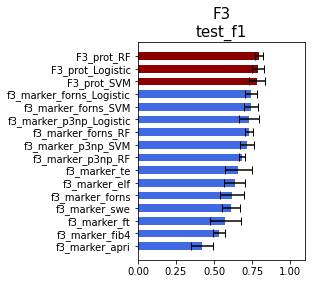

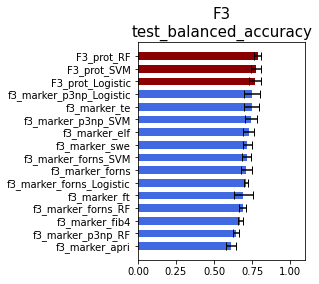

In [133]:
plot_performance(result = result_table_f3, endpoint='F3')

#### Plot ROC curve for test sets in cross validation

In [116]:
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RepeatedStratifiedKFold

In [117]:
def compute_cv_roc(X, y, endpoint):
    
    tprs = []
    roc_aucs = []
    base_fpr = np.linspace(0, 1, 101)
    
    plt.figure(figsize=(4, 4))
    
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
    for i, (train_index, test_index) in enumerate(rskf.split(X,y)):
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        
        model = clf_sklearn['Logistic'].fit(X_train, y_train)
        y_score = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        plt.plot(fpr, tpr, 'royalblue', alpha=0.05)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0]=0.0
        tprs.append(tpr)
    
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    
    tprs_upper = mean_tprs + std
    tprs_lower = mean_tprs - std
    
    mean_rocauc = np.mean(roc_aucs).round(2)
    sd_rocauc = np.std(roc_aucs).round(2)
    
    plt.plot(base_fpr, mean_tprs, color = 'royalblue', 
             label = 'Mean ROC\n(AUC = {}±{})'.format(mean_rocauc, sd_rocauc))
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.4, label = '±1 std. dev')
    
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.02])
    plt.ylim([-0.01, 1.02])
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(fontsize = 12)
    plt.title('{}\nProteomic panel'.format(endpoint), fontsize = 15)
    plt.savefig('figures/ROC_{}.png'.format(endpoint), dpi=120, bbox_inches='tight')

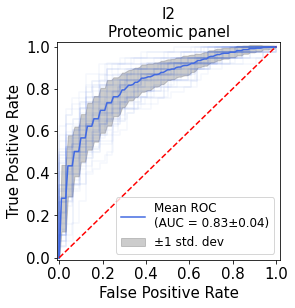

In [136]:
y = inflamation_ge_2.astype(int)
_X = data_proteomics[proteins_selected_I2.index]
in_both = y.index.intersection(_X.index)
_X = _X.loc[in_both]
_y = y.loc[in_both]

compute_cv_roc(X=_X, y=_y, endpoint='I2')

## Multiclass, Multivariate Models
- predict single classes for each endpoint in a joint model.
- 

### Multiclass Fibrosis
- Predict 4 categories for fibrosis

In [119]:
kleiner_score = Y.kleiner.dropna()
y = kleiner_score

In [120]:
indices = data_proteomics.index.intersection(y.index)
X_train = data_proteomics.loc[indices]
y = y.loc[indices].astype(int)

In [121]:
clf_rf.fit(X_train, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=29, verbose=0,
                       warm_start=False)

In [122]:
clf_rf.classes_

array([0, 1, 2, 3, 4])

In [123]:
y_train_pred = sklms.cross_val_predict(clf_rf, X_train, y, cv=5)

In [124]:
conf_mx = sklm.confusion_matrix(y, y_train_pred)
conf_mx

array([[ 0, 34,  1,  0,  0],
       [ 0, 97, 26,  0,  1],
       [ 0, 45, 51,  0, 10],
       [ 0,  3, 12,  0, 12],
       [ 0,  0, 18,  0, 48]])

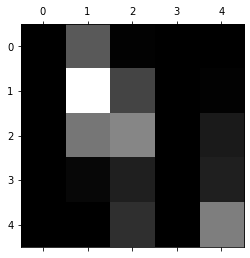

In [125]:
plt.matshow(conf_mx, cmap=plt.cm.gray) 
plt.show()

In [126]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
display(row_sums)
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[ 35],
       [124],
       [106],
       [ 27],
       [ 66]])

array([[0.        , 0.97142857, 0.02857143, 0.        , 0.        ],
       [0.        , 0.78225806, 0.20967742, 0.        , 0.00806452],
       [0.        , 0.4245283 , 0.48113208, 0.        , 0.09433962],
       [0.        , 0.11111111, 0.44444444, 0.        , 0.44444444],
       [0.        , 0.        , 0.27272727, 0.        , 0.72727273]])

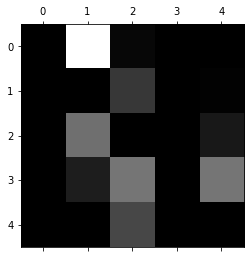

In [127]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [128]:
sklm.accuracy_score(y, y_train_pred)

0.547486033519553

### Multiclass model inflammation

### Multiclass model steatosis

### Joint prediction of the three multiclass targets

## Versions

In [129]:
pip list | grep pandas

pandas                0.25.3      
You should consider upgrading via the '/Users/niulili/projects/ALD-study-H/env_ald/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [130]:
pip list | grep scikit

scikit-learn          0.22.2.post1
You should consider upgrading via the '/Users/niulili/projects/ALD-study-H/env_ald/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
